# Task 1: Poisoning Attacks

## Dependencies

In [ ]:
import copy
import numpy as np
import os

### If you are using Google Colab, you need to upload this notebook and the codebase to your Google Drive. Then you need to mount your Google Drive in Colab and set your working directory. If you are running on your local machine, you can ignore the following line.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = "/content/drive/My Drive/"
project_dir = "Assignment2" # Change to your path
os.chdir(root_dir + project_dir)

In [ ]:
# Make sure the path is correct
!ls

attack.py			    dataset
CS5562_Assignment_2_Task1.ipynb     defense.py
CS5562_Assignment_2_Task2.ipynb     environment.yml
CS5562_Assignment_2_Task3.ipynb     model.py
CS5562_Assignment_2_Task4.ipynb     __pycache__
CS5562_Assignment_2_Warm_ups.ipynb  utilities.py


## Implement KKT attack

In [ ]:
from utilities import *
from attack import Attack
from tqdm import tqdm

import cvxpy as cp

In [ ]:
class KKT_Attack(Attack):
    """
        KKT attack
    """
    def attack(self, eps):
        n_poison = int(eps * len(self.clean_dataset))

        ####################
        # TODO: update the following part to build your attack model based on KKT attack

        # Find decoy parameters theta_decoy
        svm_clean = copy.deepcopy(self.target_model)
        svm_clean.train(self.clean_dataset)

        test_data_flip = dataset(self.test_dataset.X, self.test_dataset.Y*(-1))
        test_loss = svm_clean.individual_loss(test_data_flip)
        gamma = np.percentile(test_loss, 50, axis=0)
        index = np.where(test_loss > gamma)[0]
        x, y = test_data_flip[index]
        print(len(index))

        # Changed value of repeat (r) from [1000 - 5000] and chose 5000 empirically
        repeats = [20][0]
        x_flip = np.tile(x, (repeats, 1))
        y_flip = np.tile(y, repeats)
        print(x_flip.shape)

        D_flip = dataset(x_flip, y_flip)
        D_decoy = combine_datset(self.clean_dataset, D_flip)

        svm_decoy = copy.deepcopy(self.target_model)
        svm_decoy.train(D_decoy)
        print(svm_decoy.score(self.test_dataset))
        print("Decoy theta found!")

        # Grid search
        def hinge_grad(data, model):
          w = model.coef_[0]
          b = model.intercept_
          X, Y = data.X, data.Y
          grad = 0

          for (x_, y_) in zip(X, Y):
              v = y_ * (np.dot(w, x_) + b)
              grad += 0 if v > 1 else -y_ * x_
          return grad / X[0].shape

        def optimization(n_features, eps_pos, eps_neg, g_decoy, model):
          w = model.coef_
          b = model.intercept_
          x_pos = cp.Variable(n_features)
          x_neg = cp.Variable(n_features)

          error = g_decoy - eps_pos*x_pos + eps_neg*x_neg
          obj = cp.Minimize(cp.sum_squares(error))
          constraints = [
              1 - (w@x_pos + b) >= 0,
              1 + (w@x_neg + b) >= 0
          ]

          prob = cp.Problem(obj, constraints)
          prob.solve()
          x_pos = np.array(x_pos.value)
          x_neg = np.array(x_neg.value)

          return x_pos, x_neg

        T = 5
        optimal_params = None
        g_decoy = hinge_grad(self.clean_dataset, svm_decoy.model)

        for t in tqdm(range(1, T-1)):
        # for t in tqdm(range(1)):
          eps_pos = t*eps / T
          eps_neg = eps - eps_pos

          # Get x_pos, x_neg
          features = self.clean_dataset.X[0].shape
          x_pos, x_neg = optimization(features, eps_pos, eps_neg, g_decoy, svm_decoy.model)

          # Create D_poison
          n_pos = int(eps_pos * len(self.clean_dataset))
          n_neg = n_poison - n_pos

          x = np.concatenate((np.tile(x_pos, (n_pos, 1)), np.tile(x_neg, (n_neg, 1))))
          y = np.concatenate((np.ones(n_pos), (-1)*np.ones(n_neg)))
          D_poison = dataset(x, y)
          assert len(D_poison) <= n_poison

          # Train svm
          D_combine = combine_datset(self.clean_dataset, D_poison)
          svm_new = copy.deepcopy(self.target_model)
          svm_new.train(D_combine)

          # Get svm, D_poison with highest test loss
          test_loss = svm_new.score(self.test_dataset)[0]

          if optimal_params is None or optimal_params['loss'] < test_loss:
            optimal_params = {
                'x_poison': x,
                'y_poison': y,
                'loss': test_loss,
                'eps_pos': eps_pos,
                'eps_neg': eps_neg
                }
          print(optimal_params['loss'], optimal_params['eps_pos'], optimal_params['eps_neg'])

        X_modified = optimal_params['x_poison']
        Y_modified = optimal_params['y_poison']

        ####################

        return dataset(X_modified, Y_modified)

# Test your code

## Helper functions

In [ ]:
def compute_attack_grade(attack, victim_model,eps,clean_train_dataset,test_dataset):
    # target model structure is known to the adversary
    target_model = copy.deepcopy(victim_model)
    if attack == 'KKT':
        attacker = KKT_Attack(target_model,clean_train_dataset,test_dataset)
    elif attack == 'label-flip':
        attacker = Label_Flip_Attack(target_model, clean_train_dataset, test_dataset)
    elif attack == 'adaptive':
        attacker = Adaptive_Attack(target_model, clean_train_dataset, test_dataset)
    elif attack == 'random-label-flip':
        attacker = Random_Label_Flip_Attack(target_model, clean_train_dataset, test_dataset)
    poisoned_dataset = attacker.attack(eps)
    assert len(poisoned_dataset) <= int(eps*len(clean_train_dataset))

    train_dataset = combine_datset(clean_train_dataset,poisoned_dataset)
    clean_model = copy.deepcopy(target_model)

    # performance without any attack
    clean_model.train(clean_train_dataset)
    clean_loss,clean_acc = clean_model.score(test_dataset)
    print('\nAvg loss of clean model: %0.5f, avg classification accuracy: %0.5f'%(clean_loss,clean_acc))

    # attack the victim model
    victim_model.train(train_dataset)
    poisoned_loss,poisoned_acc =victim_model.score(test_dataset)
    print('\nAvg loss of poisoned model:%0.5f, avg classification accuracy: %0.5f'%(poisoned_loss,poisoned_acc))

    grade = poisoned_loss - clean_loss

    # for generating figures
    distance_to_center_diff(clean_train_dataset,poisoned_dataset)
    loss_diff(clean_train_dataset, poisoned_dataset,clean_model)

    return len(poisoned_dataset)/len(clean_train_dataset),grade

## Testing

1081
(21620, 784)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(1.3081369244429388, 0.4294960702727693)
Decoy theta found!


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|███▎      | 1/3 [01:05<02:10, 65.49s/it]

0.13875204700214022 0.04 0.16


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 67%|██████▋   | 2/3 [02:18<01:10, 70.00s/it]

0.13875204700214022 0.04 0.16


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 3/3 [03:30<00:00, 70.18s/it]


0.13875204700214022 0.04 0.16

Avg loss of clean model: 0.01694, avg classification accuracy: 0.99260


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Avg loss of poisoned model:0.13875, avg classification accuracy: 0.95885
[[5.30393598]
 [5.63018176]
 [4.60116321]
 ...
 [6.14406988]
 [7.70754142]
 [4.98865878]]


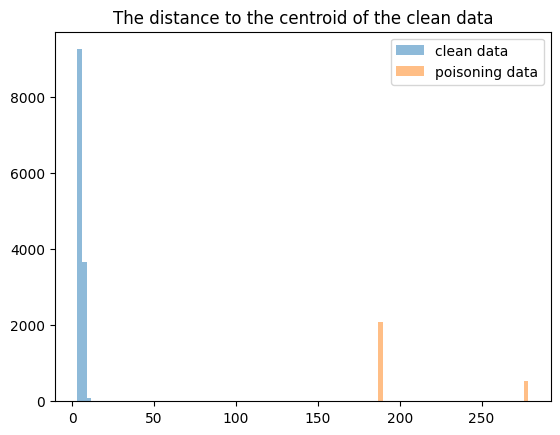

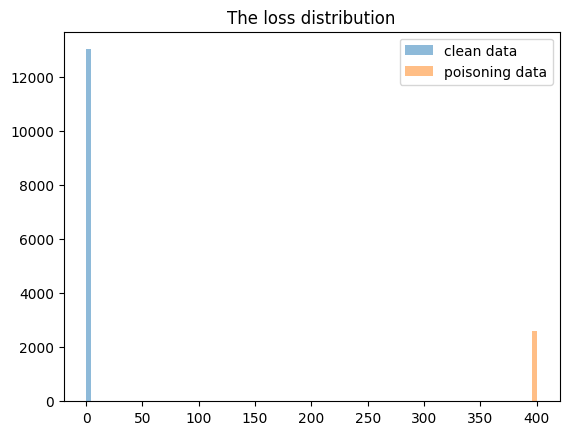



-----------result---------
KKT attack against undefended svm model on mnist_17 dataset: 0.12 (0.20 fraction of poisoning data)


In [ ]:
from model import Undefended_Model

train_dataset,test_dataset = load_dataset('mnist_17')
base_model = load_model("svm", "mnist_17")
target_model = Undefended_Model(base_model,"svm")
defense_name = 'undefended'
fraction, attack_grade = compute_attack_grade("KKT", target_model, 0.2, train_dataset, test_dataset)
print('\n\n-----------result---------')
print('%s attack against %s %s model on %s dataset: %0.2f (%0.2f fraction of poisoning data)'%("KKT",defense_name,"svm","mnist_17",attack_grade,fraction))

# Report

**Q.1) Please explain your attack algorithm specifying how you find $\theta_{decoy}$ in Step 1 and whether the victim model trained on the poisoned training dataset has a similar parameter as $\theta_{decoy}$ (the parameter you find in Step 1).**


Step 1: Estimating $\theta_{decoy}$
1. Train the model on clean dataset $D_C$ and retrieve the parameters $θ_c$.
2. Flip all the labels of the test dataset $D_{test}$. 
2. Using $\theta_c$ calculate individual loss on flipped test dataset.
3. Select data points that have losses greater than some arbitrary threshold $\gamma$.
4. Create $D_{flip}$ by repeating the above selected points $r$ times. This acts as our decoy poisoned dataset.
5. Combine $D_{flip}$ with $D_C$ and extract the model parameters $\theta_{decoy}$.

Step 2: Finding the poisoned dataset $D_P$

KKT condition:
$$\sum_{(x, y) 𝛜 D_C} ∇_{\theta}l(\theta_{decoy}; x, y) \space + \sum_{(x̃, ỹ) 𝛜 D_P} ∇_{\theta}l(\theta_{decoy}; x̃, ỹ) = 0$$

Note: In [1] the authors are adding $λ\theta_{decoy}$ in the objective to account for the regularization used in hinge_loss. I am eliminating this term from the objective since my model does not use regularization.

$$\underset{x̃_+, x̃_-, ϵ_+, ϵ_-}{minimize} \space || g_{\theta_{decoy}, D_C} - ϵ_+ x̃_+ + ϵ_-x̃_-||_2^2$$

Constraints:

$$\theta_{decoy} \cdot x_+ <= 1$$
$$-(\theta_{decoy} \cdot x_-) <= 1$$
$$\epsilon_+ + ϵ_- = ϵ$$
$$(x̃_+, +1), (x̃_-, -1) \space 𝛜 \space 𝓕_β$$

The first two constraints ensure that the $x̃_+, x̃_-$ generated act as the support vectors for the new model. The next constraint makes sure that number of copies do not exceed the budget of the adversary.

In the last constraint $𝓕_β$ represents the feasible set, for this task the feasible set is all the valid pixel values since we are not assuming any defense.

Initially I generated multiple $\theta_{decoy}$, then selected the one which had the lowest train loss and highest test loss. Using my selected $\theta_{decoy}$, I calculate $g_{\theta_{decoy}, D_C}$.

Solving the above minimization: I am using cvxpy which is a general purpose convex solver to generate the images. 

To find $x̃_+, x̃_-$ I ran a grid search over epsilons and selected the configuration that had the highest test loss.

$r = 20, \space τ = 0.5, \space ϵ_+ = 0.04, \space ϵ_- = 0.16$

My final scores are as follows:
```
Avg loss of clean model: 0.01694, avg classification accuracy: 0.99260
Avg loss of poisoned model:0.13875, avg classification accuracy: 0.95885
```

**It is to note that by selecting different values of $\gamma$ and $r$, we can further bring down the accuracy of the poisoned model for sure. I have demonstrated the attack here with one such empirically chosen value.**


### Is the new model similar to $\theta_{decoy}$?

The model trained on $D_C \space ⋃ \space D_P$ performs similarly to the $\theta_{decoy}$ model. It's loss is closer to the loss of $\theta_{decoy}$ on the test dataset.

If we compute the following:

1. $||\theta_{decoy} - \theta_{obtained}||_2 / N = 0.01658$

2. $||\theta_{clean} - \theta_{decoy}||_2 / N = 0.02041$

If we compare these values we can see that in 1. on average elements in $\theta_{obtained}$ are differing from the $\theta_{decoy}$ by $0.01658$ which is lower than $0.02041$. Therefore, we can say with some confidence that $\theta_{obtained}$ is moving towards the ideal $\theta$.

### Question 1: Compare the attack success rates of your KKT attack and your label flipping attack on the SVM models. Which attack has a higher success rate and why?

Answer: KKT attack is stronger than label flipping and has a higher success rate because of the following reasons:

1. In KKT the adversary has more control over the data. The adversary can manipulate the input features as well as the labels. Whereas, in label flipping they could only control the labels of the data.

2. If you notice in KKT attack we are adding $\theta_{decoy} \cdot x_+ + b_{decoy} <= 1$ and $-(\theta_{decoy} \cdot x_- + b_{decoy}) <= 1$ in our constraints. This ensures that the points we are generating will act as a support vector and guarantees that the decision boundary will change. We do not have these guarantees for label flipping.
Moreover, the optimization results from the implicit theorem which states that the sum of optimal parameters should equal to 0. This always results in an optimal solution since it is convex for an SVM.


### References:

[1] Pang Wei Koh, Jacob Steinhardt, and Percy Liang. Stronger data poisoning attacks
break data sanitization defenses. arXiv preprint arXiv:1811.00741, 2018.


### Problems and Learnings

Initially, I was selecting points for obtaining my $\theta_{decoy}$ that had the largest loss on the test_data, instead of selecting points with the largest loss on the flipped test data. That is conceptually wrong and was resulting in a maximum of 1% accuracy drop only.
